- Name: `dissipation-theory--Study-28.ipynb`
- Author: John A. Marohn
- Date: 2024-10-13
- Continued from: `dissipation-theory--Study-26.ipynb`
- Continued to: ---
- Summary: Redo `Study 26` using numba/jit-accelerated functions coded in `dissipationtheory.dissipation3`.  The numba/jit functions run below are 100 to 200 times faster than their pure-Python counterparts run in `Study 26`, enabling us to plot here a more detailed BLDS spectrum and explore friction and the zero-frequency limit of the BLDS spectrum as a function of many more conductivity points.

# Preliminaries

In [1]:
import numpy as np
import pandas

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import cycler

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 3.25, 3.5

In [3]:
THIS = 'dissipation-theory--Study-28--'
fig = {}

In [4]:
from dissipationtheory.constants import ureg, qe, epsilon0
from dissipationtheory.dissipation3 import CantileverModel, SampleModel1, SampleModel2
from dissipationtheory.dissipation3 import CantileverModelJit, SampleModel1Jit, SampleModel2Jit
from dissipationtheory.dissipation3 import theta1norm, gamma_perpendicular
from dissipationtheory.dissipation3 import theta1norm_jit, gamma_perpendicular_jit
from dissipationtheory.dissipation3 import blds_perpendicular, blds_perpendicular_jit
from dissipationtheory.dissipation3 import gamma_perpendicular_approx, BLDSzerohigh, BLDSzerolow, BLDSapproxK2

# Sample object

Set up pure Python objects.

In [5]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(75, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(35, 'nm'), 
    d = ureg.Quantity(38, 'nm')
)

In [6]:
sample1 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(500, 'nm'),
    epsilon_s = ureg.Quantity(complex(3, -0.2), ''),  # <== edit this
    sigma = ureg.Quantity(1E-5, 'S/m'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(300, 'nm')
)

In [7]:
sample1

cantilever

      resonance freq = 75.000 kHz
                     = 4.712e+05 rad/s
     spring constant = 2.800 N/m
  tip-sample voltage = 1.000 V
              radius = 35.000 nm
              height = 38.000 nm

semiconductor

             epsilon (real) = 3.000
             epsilon (imag) = -0.200
                  thickness = 500.0 nm
               conductivity = 1.000e-05 S/m
             charge density = 1.000e+21 m^{-3}
           reference height = 3.000e+02 nm

         roll-off frequency = 1.129e+06 Hz
                   mobility = 6.242e-08 m^2/(V s)
         diffusion constant = 1.614e-09 m^2/s
               Debye length = 3.780e+01 nm
           diffusion length = 5.852e+01 nm
   effective epsilon (real) = 3.000
   effective epsilon (imag) = -2.597

dielectric

  epsilon (real) = 1000000.000
  epsilon (imag) = 0.000
       thickness = infinite

Magically, set up the jit sample model from the pure Python sample model, as described in `Study 27`.

In [8]:
sample1_jit = SampleModel1Jit(**sample1.args())

In [9]:
sample1_jit.print()

cantilever
   cantilever freq =  75000.0 Hz
                   =  471238.89803846896 rad/s
   spring constant =  2.8 N/m
tip-sample voltage =  1.0 V
            radius =  3.5e-08 m
            height =  3.8e-08 m

semiconductor
          epsilon (real) =  3.0
          epsilon (imag) =  -0.2
               thickness =  5.000000000000001e-07 m
            conductivity =  1e-05 S/m
          charge density =  1e+21 m^{{-3}}
        reference height =  3.0000000000000004e-07 m
 
      roll-off frequency =  1129409.0673730192 Hz
                mobility =  6.241509090043337e-08 m^2/(V s)
      diffusion constant =  1.6135549206567651e-09 m^2/s
            Debye length =  3.7797775481848936e-08 m
        diffusion length =  5.851555252782804e-08 m
effective epsilon (real) =  3.0
effective epsilon (imag) =  -2.5966804779363124

dielectric
 epsilon (real) =  1000000.0
 epsilon (imag) =  0.0
      thickness = infinite


# Example friction calculation

Spot-check the new friction-calculation code by comparing a numba/jit result to a pure-Python result.

First, the numba/jit result.

In [10]:
%%time
ans1a = gamma_perpendicular_jit(theta1norm_jit, sample1_jit)
ans1a 

CPU times: user 6.99 ms, sys: 231 µs, total: 7.22 ms
Wall time: 7.14 ms


Magnitude,[64.73496892335902 14.709831956501283 1.7066692024195118]
Units,piconewton second/meter


Now the pure Python result.

In [11]:
%%time
ans1b = gamma_perpendicular(theta1norm, sample1)
ans1b 

CPU times: user 2.42 s, sys: 29.5 ms, total: 2.45 s
Wall time: 2.57 s


Magnitude,[64.73496892335896 14.709831956501262 1.7066692024195087]
Units,piconewton second/meter


By inspection we get the same result for the three terms' contribution to the friction.  Success!

The numba/jit calculation is 100 to 200 times faster.  

# Example BLDS calculation

Compare the execution time for pure-Python and numba/jit calculations.

In [12]:
omega_m = ureg.Quantity(2 * np.pi * np.logspace(1, 2, 2), 'Hz')

In [13]:
%%time
ans2a = blds_perpendicular_jit(theta1norm_jit, sample1_jit, omega_m)
ans2a 

CPU times: user 28 ms, sys: 2.12 ms, total: 30.1 ms
Wall time: 31.3 ms


Magnitude,[[-2.980187914386668 -0.4771232443830765 -0.7077967722895434] [-2.980195172459724 -0.47712335645508763 -0.7076921347981979]]
Units,hertz


In [14]:
%%time
ans2b = blds_perpendicular(theta1norm, sample1, omega_m)
ans2b 

CPU times: user 6.23 s, sys: 55.4 ms, total: 6.28 s
Wall time: 6.5 s


Magnitude,[[-2.9801879143866694 -0.4771232443830761 -0.7077967722895439] [-2.9801951724597258 -0.4771233564550871 -0.7076921347981985]]
Units,hertz


By inspection we get the same result for the two terms' contribution to the BDLS frequency shift at the .  Success!

The numba/jit calculation is 150 to 200 times faster.  

# Create list of modulation frequencies and charge densities

Set up arrays of modulation frequency $\omega_{\mathrm{m}}$ and conductivity $\sigma$.

In [15]:
N_omega = 100
N_sigma = 50

In [16]:
omega_m = ureg.Quantity(
    np.logspace(
        start=np.log10(1e1),
        stop=np.log10(1e8),
        num=N_omega), 'Hz')

In [17]:
sigma = ureg.Quantity(
    np.logspace(
        start=np.log10(1e-9),
        stop=np.log10(1),
        num=N_sigma), 'S/m')

Assume a fixed mobility of $\mu = 10^{-8} \: \mathrm{m}^2/\mathrm{V s}$, an ionic mobility.  

In [18]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 

As we vary $\sigma$, we should vary the charge density $\rho$ to keep the mobility constant.

In [19]:
rho = (sigma / (qe * mu)).to('1/m^3')

Get ready to run the simulations.

In [20]:
data = {}        # many simulations
data['01'] = {}  # the first simulation

Loop over conductivities, computing the BLDS spectrum and the friction.  This takes about 

In [21]:
%%time

# remember
sigma0 = sample1_jit.sigma
rho0 =  sample1_jit.rho

# set
for rho_, sigma_ in zip(rho, sigma):

    sample1_jit.rho = rho_.to('1/m^3').magnitude
    sample1_jit.sigma = sigma_.to('S/m').magnitude

    gamma = gamma_perpendicular_jit(theta1norm_jit, sample1_jit).to('pN s/m')
    f_BLDS = blds_perpendicular_jit(theta1norm_jit, sample1_jit, omega_m).to('Hz')
    
    data['01'][str(sigma_.to('S/m').magnitude)] = {
        'omega_m': omega_m,
        'f_BLDS': f_BLDS, 
        'gamma': gamma,
        'sigma': ureg.Quantity(sample1_jit.sigma, 'S/m'),
        'd': ureg.Quantity(sample1_jit.cantilever.d, 'm'),
        'rho': ureg.Quantity(sample1_jit.rho, '1/m^3'),
        'LD': ureg.Quantity(sample1_jit.LD, 'm'),
        'omega_c': ureg.Quantity(sample1_jit.cantilever.omega_c, 'Hz'),
        'omega_0': (ureg.Quantity(sample1_jit.sigma, 'S/m')/epsilon0).to('Hz')}

# reset
sample1_jit.rho = rho0
sample1_jit.sigma = sigma0

CPU times: user 11.9 s, sys: 109 ms, total: 12 s
Wall time: 12.1 s


Explore the `data['01']` object.  The keys are the conductivity in S/m, running from $10^{-9}$ to $1$.

In [22]:
(list(data['01'].keys())[0],
 list(data['01'].keys())[-1])

('1e-09', '1.0')

The BLDS frequencies are given as a $100 \times 3$ array, with $100$ being the number of modulation frequencies and $3$ being the number of terms in Loring's sum.

In [23]:
data['01']['1e-09']['f_BLDS'].shape

(100, 3)

To get the BLDS frequency, sum up the three components.  We do this by summing over the second dimension.

In [24]:
data['01']['1e-09']['f_BLDS'].sum(axis=1)[0]

<Quantity(-3.6261448167750916, 'hertz')>

From `Study 25`, a helper function to plot the BLDS spectra.  Make sure to add up the three terms to get the total BLDS frequency shift.

In [25]:
def plotBLDS(data):

    rho = np.zeros(len(data))    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude

    # colormap = plt.cm.jet
    colormap = plt.cm.magma_r
    color_list = [colormap(i) for i in np.linspace(0, 1, len(data))]

    normalized_colors = mcolors.LogNorm(vmin=min(rho), vmax=max(rho))
    scalar_mappable = cm.ScalarMappable(norm=normalized_colors, cmap=colormap)
    scalar_mappable.set_array(len(color_list))
    
    fig, ax = plt.subplots(figsize=(4.5, 3))
    for index, key in enumerate(data.keys()):
        
        with plt.style.context('seaborn-v0_8'):
            plt.semilogx(
                data[key]['omega_m'].to('Hz').magnitude,
                np.abs(data[key]['f_BLDS'].sum(axis=1).to('Hz').magnitude),
                '-',
                color=color_list[index])

    # color bar
    clb=plt.colorbar(scalar_mappable, ax=ax)
    clb.ax.set_title(r'$\rho \: [\mathrm{cm}^{-3}]$', fontsize=12)
    
    plt.ylabel('|$\Delta f_{\mathrm{BLDS}}$| [Hz]')
    plt.xlabel('mod. freq. $\omega_{\mathrm{m}}$ [rad/s]')
    plt.tight_layout()
    plt.show()
    
    return fig

Plot every 3rd BLDS spectrum.

In [26]:
data['01-short'] = {}
for key in list(data['01'].keys())[::3]:
    data['01-short'][key] = data['01'][key]

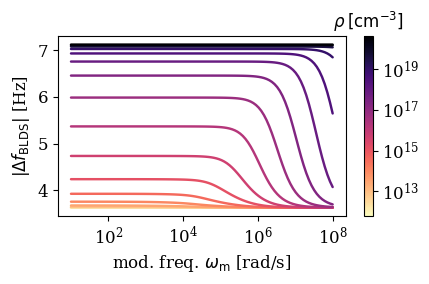

In [27]:
fig['01'] = plotBLDS(data['01-short'])

I have rewritten the `BLDSlimits` function to return low-density and high-density limits for all three terms; see `BLDSzerohigh` and `BLDSzerolow` in `dissipation3`.  I want to rewrite the plotting function below, `plotme`, to use these new function.  

I think I can consense the code considerably by using `pandas` dataframes.  Convert `data['01']` to a `pandas` dataframe and explore.

In [28]:
df = pandas.DataFrame.from_dict(data['01'])
df

,1e-09,1.5264179671752366e-09,2.3299518105153718e-09,3.556480306223136e-09,5.4286754393238595e-09,8.28642772854686e-09,1.2648552168552958e-08,1.9306977288832496e-08,2.9470517025518096e-08,4.498432668969444e-08,...,0.022229964825261957,0.0339322177189533,0.05179474679231213,0.07906043210907701,0.12067926406393313,0.18420699693267165,0.2811768697974237,0.42919342601287785,0.6551285568595523,1.0
omega_m,"[10.0 hertz, 11.768119524349984 hertz, 13.8488...","[10.0 hertz, 11.768119524349984 hertz, 13.8488...","[10.0 hertz, 11.768119524349984 hertz, 13.8488...","[10.0 hertz, 11.768119524349984 hertz, 13.8488...","[10.0 hertz, 11.768119524349984 hertz, 13.8488...","[10.0 hertz, 11.768119524349984 hertz, 13.8488...","[10.0 hertz, 11.768119524349984 hertz, 13.8488...","[10.0 hertz, 11.768119524349984 hertz, 13.8488...","[10.0 hertz, 11.768119524349984 hertz, 13.8488...","[10.0 hertz, 11.768119524349984 hertz, 13.8488...",...,"[10.0 hertz, 11.768119524349984 hertz, 13.8488...","[10.0 hertz, 11.768119524349984 hertz, 13.8488...","[10.0 hertz, 11.768119524349984 hertz, 13.8488...","[10.0 hertz, 11.768119524349984 hertz, 13.8488...","[10.0 hertz, 11.768119524349984 hertz, 13.8488...","[10.0 hertz, 11.768119524349984 hertz, 13.8488...","[10.0 hertz, 11.768119524349984 hertz, 13.8488...","[10.0 hertz, 11.768119524349984 hertz, 13.8488...","[10.0 hertz, 11.768119524349984 hertz, 13.8488...","[10.0 hertz, 11.768119524349984 hertz, 13.8488..."
f_BLDS,"[[-2.6979093482955756 hertz, -0.39730981074967...","[[-2.698090920476028 hertz, -0.397398186774877...","[[-2.6983674867279683 hertz, -0.39753241648504...","[[-2.6987882869148323 hertz, -0.39773577507361...","[[-2.6994275020298275 hertz, -0.39804270757709...","[[-2.700396176358233 hertz, -0.398503421516972...","[[-2.7018590268541582 hertz, -0.39918952093140...","[[-2.7040573179221945 hertz, -0.40020006372368...","[[-2.707338562746611 hertz, -0.401666631486690...","[[-2.7121929262941435 hertz, -0.40375531456040...",...,"[[-5.301297153206913 hertz, -0.779481738540540...","[[-5.315989440699854 hertz, -0.780921959111690...","[[-5.327926069015646 hertz, -0.782090886535537...","[[-5.337616374187242 hertz, -0.783039092587003...","[[-5.345478313238606 hertz, -0.783807915257355...","[[-5.351853815450265 hertz, -0.784431072946863...","[[-5.357021964831417 hertz, -0.784936023997015...","[[-5.361210146169432 hertz, -0.785345100592468...","[[-5.364603367369531 hertz, -0.785676447802103...","[[-5.367351995740098 hertz, -0.785944797191268..."
gamma,[42.51061503924813 piconewton * second / meter...,[42.519745468636685 piconewton * second / mete...,[42.53368142104888 piconewton * second / meter...,"[42.5549514143857 piconewton * second / meter,...",[42.587413433342135 piconewton * second / mete...,[42.63695266898253 piconewton * second / meter...,"[42.7125437462644 piconewton * second / meter,...",[42.82786556653198 piconewton * second / meter...,[43.00375093698383 piconewton * second / meter...,"[43.271890060452 piconewton * second / meter, ...",...,[1.4235854262100776 piconewton * second / mete...,[1.0641011639806957 piconewton * second / mete...,[0.8025391624920698 piconewton * second / mete...,[0.6105569516415313 piconewton * second / mete...,[0.46833782354916553 piconewton * second / met...,[0.3619874288469797 piconewton * second / mete...,[0.28171853149480214 piconewton * second / met...,[0.22059381735307013 piconewton * second / met...,[0.17365860285450738 piconewton * second / met...,[0.1373434553264919 piconewton * second / mete...
sigma,1e-09 siemens / meter,1.5264179671752366e-09 siemens / meter,2.3299518105153718e-09 siemens / meter,3.556480306223136e-09 siemens / meter,5.4286754393238595e-09 siemens / meter,8.28642772854686e-09 siemens / meter,1.2648552168552958e-08 siemens / meter,1.9306977288832496e-08 siemens / meter,2.9470517025518096e-08 siemens / meter,4.498432668969444e-08 siemens / meter,...,0.022229964825261957 siemens / meter,0.0339322177189533 siemens / meter,0.05179474679231213 siemens / mete

We want to exract the data in the rows, as numbers without units, for plotting.  Read the `rho` row and convert it to a numpy array.  Loop over the elements of the array, specify the element's units, and get the magnitude of the resulting element.  Convert the result list to a numpy array.  Print out every 10th element of the resulting arrray.

In [29]:
np.array([a.to('1/m^3').magnitude for a in df.loc['rho'].to_numpy()])[0:-1:10]

array([6.24150909e+17, 4.28572501e+19, 2.94278813e+21, 2.02066207e+23,
       1.38748528e+25])

Some of the rows return an array of arrays.  Run one of these, `omega_m`, through the same procedure.  Now we get an array of arrays, stripped of their units.

In [30]:
np.array([a.to('Hz').magnitude for a in df.loc['omega_m'].to_numpy()])[0][0:-1:10]

array([1.00000000e+01, 5.09413801e+01, 2.59502421e+02, 1.32194115e+03,
       6.73415066e+03, 3.43046929e+04, 1.74752840e+05, 8.90215085e+05,
       4.53487851e+06, 2.31012970e+07])

Generalize this procedure, simultaneously looping of all the rows and specifying each of their units.

In [31]:
adict = {}
keys = ['omega_m', 'f_BLDS', 'gamma', 'sigma', 'd', 'rho', 'LD', 'omega_c', 'omega_0']
units = ['Hz', 'Hz', 'pN s/m', 'S/m', 'm', '1/m^3', 'm', 'Hz', 'Hz']

for key, unit in zip(keys, units):
    adict[key] = np.array([a.to(unit).magnitude for a in df.loc[key].to_numpy()])

Check that the above does what we expect.  Look at the shape of the resulting arrays.  We have $50$ columns, one for each charge density.  For the spectra, we have $100$ frequencies.  Then, for the calculated signals, `f_BLDS` and `gamma`, we have three components, one from each or Loring's terms.

In [32]:
adict['rho'].shape

(50,)

In [33]:
adict['omega_m'].shape

(50, 100)

In [34]:
adict['f_BLDS'].shape

(50, 100, 3)

In [35]:
adict['gamma'].shape

(50, 3)

Check out the new code computing the limiting cases.

In [36]:
BLDSzerohigh(sample1, np.logspace(-1,1,5)).shape

(5, 3)

In [37]:
BLDSzerolow(sample1, np.logspace(-1,1,5)).shape

(5, 3)

Check out the new code for computing the linear approximation to the $K_2$ term.

In [38]:
x_sub, BLDSapprox = BLDSapproxK2(sample1, np.logspace(-3,3,100))
(x_sub.shape, BLDSapprox.shape)

((60,), (60,))

In [39]:
(x_sub.min(), x_sub.max())

(0.001, 3.7649358067924674)

Check out the new code for computing the $\gamma_{\perp}$ (a) $\rho \rightarrow 0$ limit and (b) linear $\rho$ expansion.

In [40]:
xR = adict['omega_0']/(sample1.epsilon_s.real.magnitude * adict['omega_c'])
g_low, g_approx = gamma_perpendicular_approx(sample1, xR)
(g_low.shape, g_approx.shape)

((50, 3), (50, 3))

Now rewrite the `Study 26` code.

In [41]:
def plotme(data, sample):

    df = pandas.DataFrame.from_dict(data)

    keys =  ['omega_m', 'f_BLDS', 'gamma',  'sigma', 'd', 'rho',   'LD', 'omega_c', 'omega_0']
    units = ['Hz',      'Hz',     'pN s/m', 'S/m',   'm', '1/m^3', 'm',  'Hz',      'Hz']

    adict = {}
    for key, unit in zip(keys, units):
        adict[key] = np.array([a.to(unit).magnitude for a in df.loc[key].to_numpy()])

    # (Left hand plot) 
    # Make the x-axis the unitless ratio of the height to Debye length squared,
    # which is proportional to charge density.

    xL = (adict['d']/adict['LD'])**2
    rho0L = (adict['rho']/xL)[0]
    
    # Define functions to convert from xL to rho and back again
    
    def fwdL(xL):
        return xL*rho0L

    def revL(rho):
        return rho/rho0L

    # (Right hand plot)
    # Make the x-axis the unitless ratio of omega_0 to omega_c, which
    # is proportional to conductivity and therefore charge density

    xR = adict['omega_0']/(sample.epsilon_s.real.magnitude * adict['omega_c'])
    rho0R = (adict['rho']/xR)[0]
    
    # Define functions to convert from xR to rho and back again

    def fwdR(xR):
        return xR*rho0R

    def revR(rho):
        return rho/rho0R
    
    # Now make the nice plot
    
    fig, ax = plt.subplots(1, 2, figsize=(7.5, 5))
    
    ax2L = ax[0].secondary_xaxis("top", functions=(fwdL,revL))
    ax2R = ax[1].secondary_xaxis("top", functions=(fwdR,revR))

    # xL_sub, BLDS_sub = BLDSapprox(sample, xL)
    
    with plt.style.context('seaborn-v0_8'):

        # get current color cycle
        
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        color_cycle = cycler.cycler('color', colors[0:3])
        ax[0].set_prop_cycle(color_cycle)
        ax[1].set_prop_cycle(color_cycle)
        
        # approximation for zero-freq BLDS, K2 term
        
        x_sub, BLDSapprox = BLDSapproxK2(sample1, xL)
        ax[0].semilogx(
            x_sub,
            BLDSapprox,
            ':',
            color=colors[0],
            label=['$K_2$ approx.'])

        # exact calculations
        
        ax[0].semilogx(
            xL,
            adict['f_BLDS'][:,0,:], 
            '-',
            label=['$K_2$','$K_1$','$K_0$'])
        
        ax[1].loglog(
            xR,
            adict['gamma'], 
            '-',
            label=['$K_2$','$K_1$','$K_0$'])
        
        # limiting cases
        
        nL_part = int(2*len(xL)/3)
        
        ax[0].semilogx(
            xL[0:nL_part],
            BLDSzerolow(sample1, xL)[0:nL_part,:], 
            '--')
        
        ax[0].semilogx(
            xL[-nL_part:-1],
            BLDSzerohigh(sample1, xL)[-nL_part:-1,:],
            '-.')

        nR_part = int(len(xR)/2)

        g_low, g_approx = gamma_perpendicular_approx(sample1, xR)

        ax[1].loglog(
            xR[0:nR_part],
            g_low[0:nR_part,:],
            '--')
        
        ax[1].loglog(
            xR[0:nR_part],
            g_approx[0:nR_part,:],
            ':',
            label=['$K_2$ approx','$K_1$ approx','$K_0$ approx'])

    ax[0].set_xlabel(r'$(h / \lambda_{\mathrm{D}})^2$')
    ax[0].set_ylabel(r'$\Delta f_{\mathrm{BLDS}}(\omega_{\mathrm{m}}=0)$ [Hz]')
    ax[0].legend(fontsize=9)
    ax[0].grid()
    ax[1].grid()
    
    ax[1].set_xlabel(r'$\omega_0/(\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{c}})$')
    ax[1].set_ylabel(r'$\gamma_{\perp}$ [pN s/m]')
    ax[1].legend(fontsize=9)
    ax[1].set_ylim(
        [0.95 * adict['gamma'].min(),
         1.05 * adict['gamma'].max()])
    
    ax2L.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    ax2R.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    
    plt.tight_layout()
    plt.show()
    
    return fig

Pass sample parameters via `sample1`, where the parameters have units, not via `sample1_jit`, there the parameters don't have units.

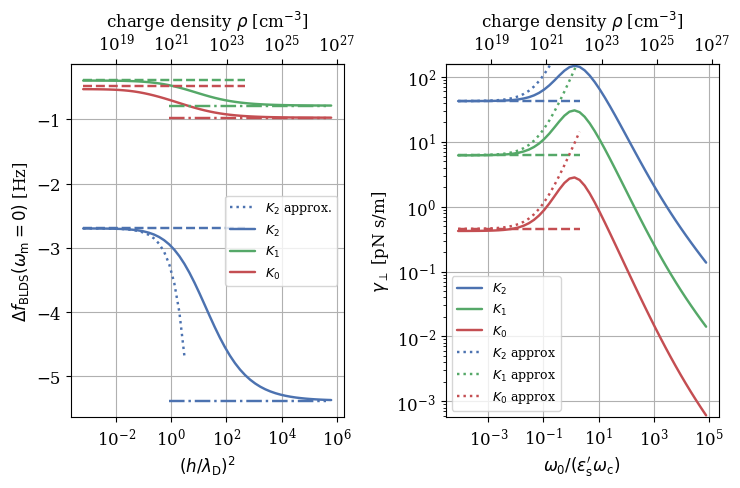

In [42]:
fig['02'] = plotme(data['01'], sample1)

# Save all figures

In [43]:
if 1:
    for num in fig.keys():
        figname = THIS + "Fig-" + num
        fig[num].savefig(figname + '.png', dpi=300)
        fig[num].savefig(figname + '.pdf')